# Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from scipy.sparse import hstack, csr_matrix
import shap
from collections import Counter
import lime
import lime.lime_tabular
from imblearn.over_sampling import SMOTE
import warnings
import joblib
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from scipy.sparse import hstack, csr_matrix
import shap
from collections import Counter
import lime
import lime.lime_tabular
from imblearn.over_sampling import SMOTE
import warnings
import joblib

In [2]:
df = pd.read_csv("yelp_dataset_after_finalization.csv")

df.head()

,business_name,review_id,user_id,date,stars_review,stars_business_average,normalized_text,lemmatized_ml,lemmatized_dl,lemmatized_bert,sentiment_label,daily_spike_score,hourly_spike_score,is_fake,max_similarity_score,most_similar_review_id
0,Acme Oyster House,qdpoNaAd2d8hz354jRKryg,M2jgPvf6syoOHGW0R8PotQ,2012-02-07 00:05:19,2,4,I grew upon seafood corn meal breaded seafood ...,"['grow', 'upon', 'seafood', 'corn', 'meal', 'b...","['grow', 'upon', 'seafood', 'corn', 'meal', 'b...","['i', 'grow', 'upon', 'seafood', 'corn', 'meal...",negative,0.000000,3.592276,0,0.264060,TiRy733reHgq5v9_ePcJSA
1,Acme Oyster House,5t14YNj5mji1aoIbt3uoQQ,akv8uZ1X6POqCWXYcnbXfA,2015-02-24 01:49:26,4,4,The Acme is a long time favorite At the age of...,"['acme', 'long', 'time', 'favorite', 'age', 'd...","['acme', 'long', 'time', 'favorite', 'age', 'd...","['the', 'acme', 'be', 'a', 'long', 'time', 'fa...",positive,1.251283,3.592276,1,0.259275,3futyMTxE8viSKTBdkM03g
2,Acme Oyster House,b2lwJxRgseknM_0B5cRkFQ,2zhTsvYOEPQaQP9w53zkvA,2010-01-07 18:09:30,2,4,A tourist site with the soul of a TGI Friday s...,"['tourist', 'site', 'soul', 'tgi', 'friday', '...","['tourist', 'site', 'soul', 'tgi', 'friday', '...","['a', 'tourist', 'site', 'with', 'the', 'soul'...",negative,0.546965,3.592276,1,0.234411,h6h7cvApI6aIV9Wdg__pPQ
3,Acme Oyster House,_BAe5c9nCJh7ntBo2YMqsQ,eZGoPMRfq2hw5LfwJg0uTA,2010-01-07 18:12:23,3,4,The wife and I had dinner there in January We ...,"['wife', 'dinner', 'january', 'go', 'early', '...","['wife', 'dinner', 'january', 'go', 'early', '...","['the', 'wife', 'and', 'i', 'have', 'dinner', ...",positive,0.546965,3.592276,1,0.260815,yKLuUKdwcvtGCBYuBi3X4A
4,Acme Oyster House,rFeHUzOELJlba9vHxvR6Ug,uBvrdhNSlGnN35NA8cSMwQ,2010-01-11 02:27:03,4,4,Based on the Yelp reviews I stopped by Acme Oy...,"['base', 'yelp', 'review', 'stop', 'acme', 'ho...","['base', 'yelp', 'review', 'stop', 'acme', 'ho...","['base', 'on', 'the', 'yelp', 'review', 'i', '...",positive,0.546965,3.592276,1,0.320177,7BBjoF6ihpS9s6f3F0iajQ


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7670 entries, 0 to 7669
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   business_name           7670 non-null   object 
 1   review_id               7670 non-null   object 
 2   user_id                 7670 non-null   object 
 3   date                    7670 non-null   object 
 4   stars_review            7670 non-null   int64  
 5   stars_business_average  7670 non-null   int64  
 6   normalized_text         7670 non-null   object 
 7   lemmatized_ml           7670 non-null   object 
 8   lemmatized_dl           7670 non-null   object 
 9   lemmatized_bert         7670 non-null   object 
 10  sentiment_label         7670 non-null   object 
 11  daily_spike_score       7670 non-null   float64
 12  hourly_spike_score      7670 non-null   float64
 13  is_fake                 7670 non-null   int64  
 14  max_similarity_score    7670 non-null   

# Analyze Imbalance Data

Class Distribution:
sentiment_label
positive    6263
negative    1069
neutral      338
Name: count, dtype: int64


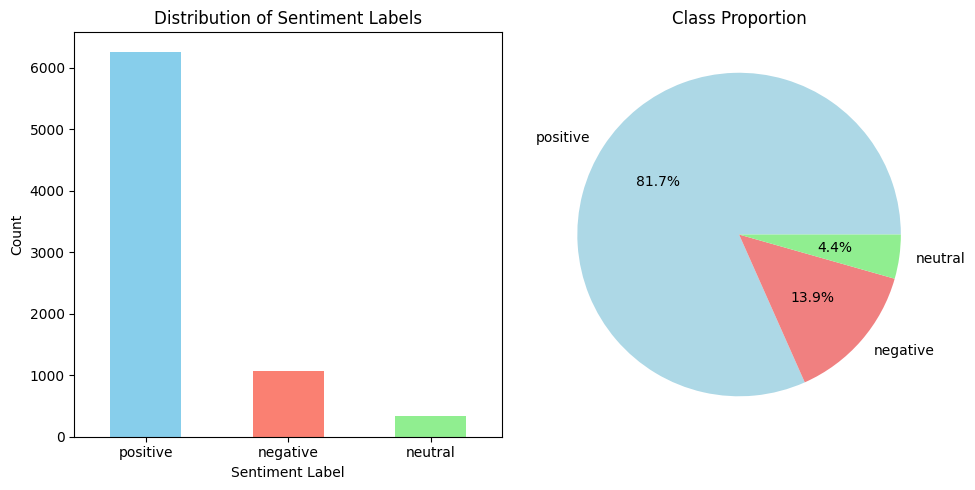

In [4]:
class_distribution = df['sentiment_label'].value_counts()
print("Class Distribution:")
print(class_distribution)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
class_distribution.plot(kind='bar', color=['skyblue', 'salmon', 'lightgreen'])
plt.title('Distribution of Sentiment Labels')
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
plt.pie(class_distribution.values, labels=class_distribution.index, autopct='%1.1f%%', colors=['lightblue', 'lightcoral', 'lightgreen'])
plt.title('Class Proportion')

plt.tight_layout()
plt.show()

# PREPROCESS TEXT DATA

In [5]:
def tokens_to_string(tokens):
    if isinstance(tokens, list):
        return ' '.join(tokens)
    elif isinstance(tokens, str):
        # Jika sudah string, coba evaluasi sebagai list
        try:
            tokens_list = eval(tokens)
            if isinstance(tokens_list, list):
                return ' '.join(tokens_list)
        except:
            return str(tokens)
    return str(tokens)

print("Mengkonversi lemmatized_ml tokens ke string...")
df['lemmatized_ml_text'] = df['lemmatized_ml'].apply(tokens_to_string)

# Cek hasil konversi
print("\nContoh data setelah konversi:")
print("Original lemmatized_ml:", df['lemmatized_ml'].iloc[0])
print("Converted text:", df['lemmatized_ml_text'].iloc[0][:300])

Mengkonversi lemmatized_ml tokens ke string...

Contoh data setelah konversi:
Original lemmatized_ml: ['grow', 'upon', 'seafood', 'corn', 'meal', 'bread', 'seafood', 'deep', 'fry', 'restaurant', 'exactly', 'advertise', 'excellent', 'cooked', 'one', 'superb', 'menu', 'deep', 'fry', 'seafood', 'experience', 'go', 'know', 'get', 'long', 'line', 'touristy', 'extremely', 'popular']
Converted text: grow upon seafood corn meal bread seafood deep fry restaurant exactly advertise excellent cooked one superb menu deep fry seafood experience go know get long line touristy extremely popular


# Split

In [6]:
train_df, temp_df = train_test_split(
    df,
    test_size=0.3,
    stratify=df['sentiment_label'],
    random_state=42
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df['sentiment_label'],
    random_state=42
)

print(f"Training set: {len(train_df)} samples ({len(train_df)/len(df)*100:.1f}%)")
print(f"Validation set: {len(val_df)} samples ({len(val_df)/len(df)*100:.1f}%)")
print(f"Test set: {len(test_df)} samples ({len(test_df)/len(df)*100:.1f}%)")

print(f"\nTraining set class distribution:")
print(train_df['sentiment_label'].value_counts())
print(f"\nValidation set class distribution:")
print(val_df['sentiment_label'].value_counts())
print(f"\nTest set class distribution:")
print(test_df['sentiment_label'].value_counts())

Training set: 5369 samples (70.0%)
Validation set: 1150 samples (15.0%)
Test set: 1151 samples (15.0%)

Training set class distribution:
sentiment_label
positive    4384
negative     748
neutral      237
Name: count, dtype: int64

Validation set class distribution:
sentiment_label
positive    939
negative    160
neutral      51
Name: count, dtype: int64

Test set class distribution:
sentiment_label
positive    940
negative    161
neutral      50
Name: count, dtype: int64


# PREPARE FEATURES

In [7]:
# Prepare text data dari lemmatized_ml
X_train_text = train_df['lemmatized_ml_text'].fillna('').astype(str)
X_val_text = val_df['lemmatized_ml_text'].fillna('').astype(str)
X_test_text = test_df['lemmatized_ml_text'].fillna('').astype(str)

# Prepare numerical features
numerical_features = ['stars_review']
print(f"Numerical features: {numerical_features}")

X_train_numerical = train_df[numerical_features].fillna(0)
X_val_numerical = val_df[numerical_features].fillna(0)
X_test_numerical = test_df[numerical_features].fillna(0)

print(f"\nNumerical features shape:")
print(f"Training: {X_train_numerical.shape}")
print(f"Validation: {X_val_numerical.shape}")
print(f"Test: {X_test_numerical.shape}")

# Scale numerical features
scaler = StandardScaler()
X_train_numerical_scaled = scaler.fit_transform(X_train_numerical)
X_val_numerical_scaled = scaler.transform(X_val_numerical)
X_test_numerical_scaled = scaler.transform(X_test_numerical)

# Encode target variable
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df['sentiment_label'])
y_val = label_encoder.transform(val_df['sentiment_label'])
y_test = label_encoder.transform(test_df['sentiment_label'])

print("Label encoding:")
for i, label in enumerate(label_encoder.classes_):
    print(f"  {i}: {label}")

Numerical features: ['stars_review']

Numerical features shape:
Training: (5369, 1)
Validation: (1150, 1)
Test: (1151, 1)
Label encoding:
  0: negative
  1: neutral
  2: positive


# TF-IDF Feature Extraction

In [8]:
print("Contoh teks training dari lemmatized_ml:")
print(X_train_text.iloc[0][:200] + "...")

Contoh teks training dari lemmatized_ml:
stop drink hear live rhythm blue catch end set drink good reasonably price...


In [9]:
print("\nMembuat TF-IDF Vectorizer dengan SublinearTF dan N-gram pada lemmatized text...")
tfidf_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    ngram_range=(1, 3),
    max_features=8000,
    min_df=2,
    max_df=0.95,
    stop_words='english'
)

# Fit dan transform pada training data
print("Fitting TF-IDF pada lemmatized training data...")
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_text)
X_val_tfidf = tfidf_vectorizer.transform(X_val_text)
X_test_tfidf = tfidf_vectorizer.transform(X_test_text)
print(f"TF-IDF dimensions - Training: {X_train_tfidf.shape}")


Membuat TF-IDF Vectorizer dengan SublinearTF dan N-gram pada lemmatized text...
Fitting TF-IDF pada lemmatized training data...
TF-IDF dimensions - Training: (5369, 8000)


# COMBINE TEXT AND NUMERICAL FEATURES

In [10]:
# Combine TF-IDF dengan numerical features
X_train_combined = hstack([X_train_tfidf, X_train_numerical_scaled])
X_val_combined = hstack([X_val_tfidf, X_val_numerical_scaled])
X_test_combined = hstack([X_test_tfidf, X_test_numerical_scaled])

# Konversi ke CSR format untuk mendukung indexing
X_train_combined = csr_matrix(X_train_combined)
X_val_combined = csr_matrix(X_val_combined)
X_test_combined = csr_matrix(X_test_combined)

print(f"Combined features dimensions - Training: {X_train_combined.shape}")

Combined features dimensions - Training: (5369, 8001)


# SMOTE

In [11]:
print("Before SMOTE:")
print(f"Class distribution: {Counter(y_train)}")

# Apply SMOTE pada combined features
smote = SMOTE(random_state=42)
X_train_combined_resampled, y_train_resampled = smote.fit_resample(X_train_combined, y_train)

print("After SMOTE:")
print(f"Class distribution: {Counter(y_train_resampled)}")

Before SMOTE:
Class distribution: Counter({np.int64(2): 4384, np.int64(0): 748, np.int64(1): 237})
After SMOTE:
Class distribution: Counter({np.int64(2): 4384, np.int64(0): 4384, np.int64(1): 4384})


# Train RF Model

In [12]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, None],
    'class_weight': ['balanced']
}

In [13]:
# Use stratified k-fold for cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Grid search untuk multi-class
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=cv,
    scoring='f1_macro',  # Gunakan f1_macro untuk multi-class
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train_combined_resampled, y_train_resampled)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Get best model
best_xgb_model = grid_search.best_estimator_

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters: {'class_weight': 'balanced', 'max_depth': None, 'n_estimators': 200}
Best cross-validation score: 0.9903


# Evaluation

In [14]:
y_test_pred = best_xgb_model.predict(X_test_combined)

print("\nTEST SET PERFORMANCE Sentiment Analysis RF:")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"F1-Score (Macro): {f1_score(y_test, y_test_pred, average='macro'):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))


TEST SET PERFORMANCE Sentiment Analysis RF:
Accuracy: 0.9166
F1-Score (Macro): 0.6169

Classification Report:
              precision    recall  f1-score   support

    negative       0.76      0.79      0.77       161
     neutral       1.00      0.06      0.11        50
    positive       0.94      0.98      0.96       940

    accuracy                           0.92      1151
   macro avg       0.90      0.61      0.62      1151
weighted avg       0.92      0.92      0.90      1151



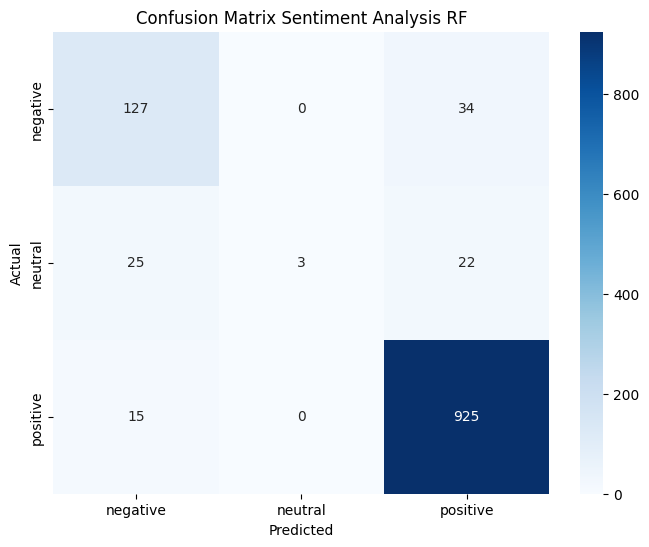

In [15]:
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix Sentiment Analysis RF')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# SHAP

Menggunakan 100 samples untuk SHAP analysis...
Menghitung SHAP values...


  0%|          | 0/100 [00:00<?, ?it/s]

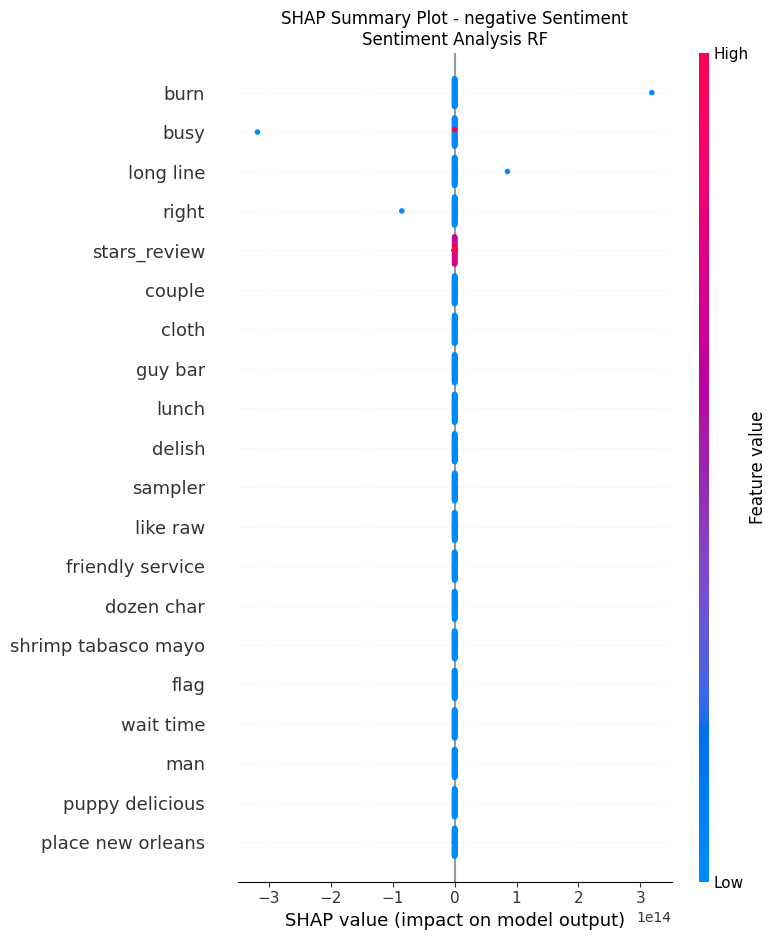

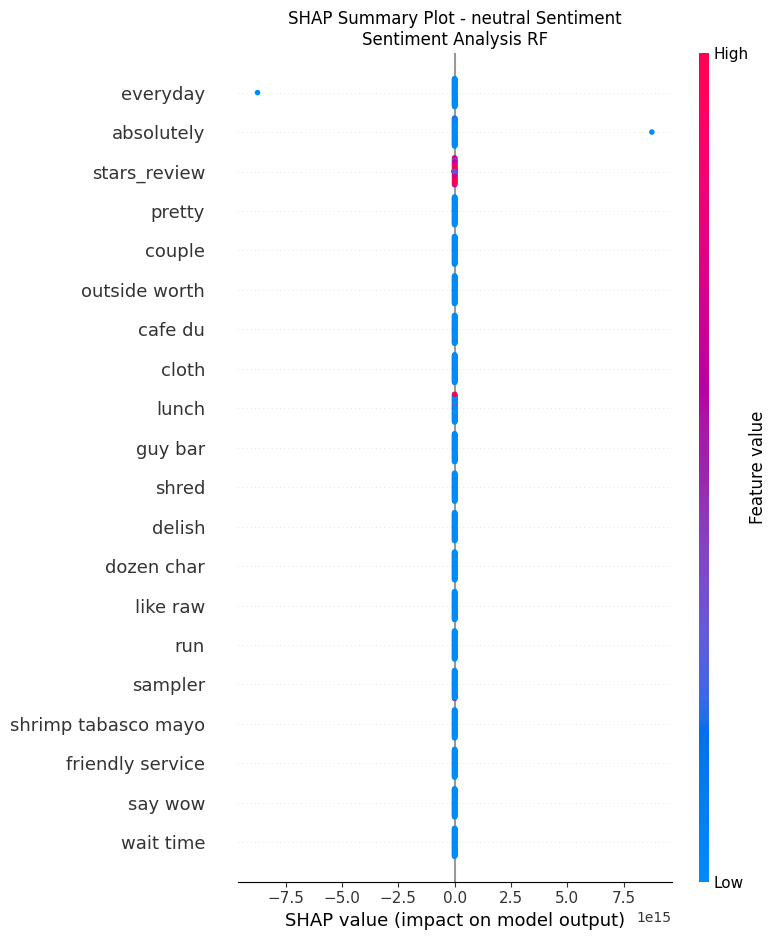

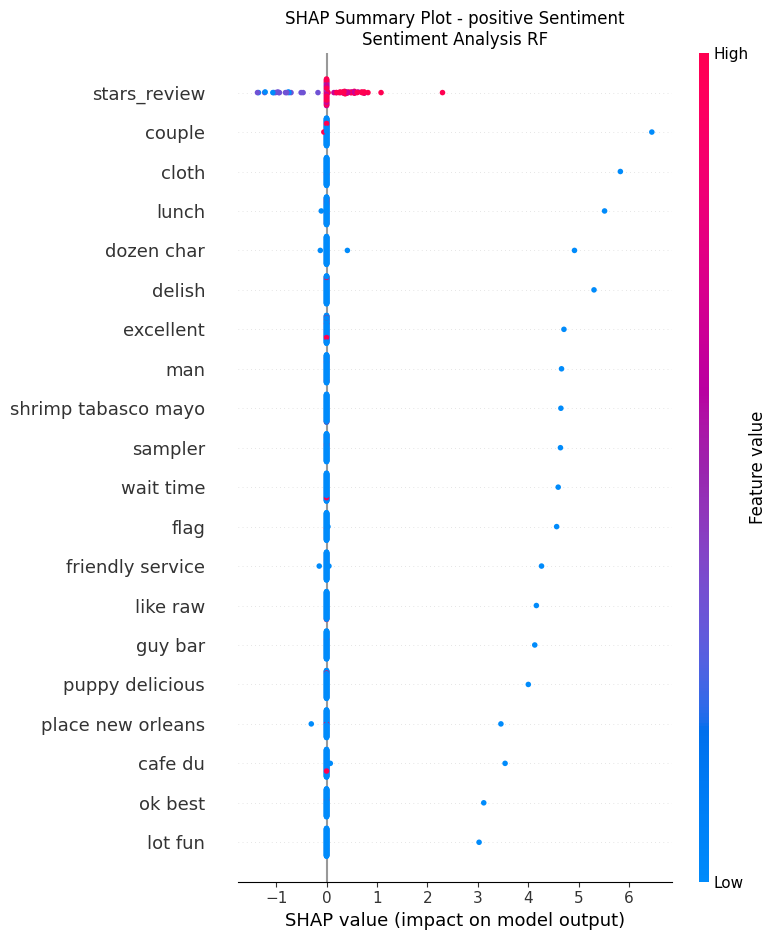

In [16]:
sample_size = min(100, X_test_combined.shape[0])
X_test_sample = X_test_combined[:sample_size]

# Buat feature names untuk combined features
feature_names = list(tfidf_vectorizer.get_feature_names_out()) + numerical_features

print(f"Menggunakan {sample_size} samples untuk SHAP analysis...")

# Convert sparse matrix to dense untuk SHAP
X_test_sample_dense = X_test_sample.toarray()

# Create SHAP explainer untuk multi-class
explainer = shap.KernelExplainer(
    model=best_xgb_model.predict_proba,
    data=X_test_sample_dense,
    link="logit"
)

# Calculate SHAP values untuk semua kelas
print("Menghitung SHAP values...")
shap_values = explainer.shap_values(X_test_sample_dense, nsamples=100)

# Plot SHAP summary untuk setiap kelas
for i, class_name in enumerate(label_encoder.classes_):
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values[:,:,i], X_test_sample_dense,
                      feature_names=feature_names,
                      show=False, max_display=20)
    plt.title(f"SHAP Summary Plot - {class_name} Sentiment\nSentiment Analysis RF")
    plt.tight_layout()
    plt.show()

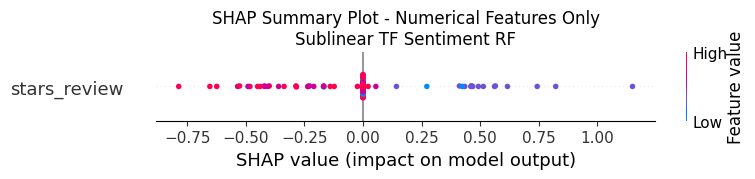

In [17]:
# SHAP summary untuk numerical features saja
numerical_indices = [len(feature_names) - len(numerical_features) + i for i in range(len(numerical_features))]
shap_values_numerical = shap_values[:, numerical_indices, 1]

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_numerical, X_test_sample_dense[:, numerical_indices], 
                  feature_names=numerical_features,
                  show=False)
plt.title("SHAP Summary Plot - Numerical Features Only\nSublinear TF Sentiment RF")
plt.tight_layout()
plt.show()

In [18]:
shap_df = pd.DataFrame({
    'feature': feature_names,
    'importance': np.abs(shap_values[:,:,1]).mean(0)
})
shap_df = shap_df.sort_values('importance', ascending=False)

print("\nTop 20 Features by SHAP Importance:")
print(shap_df.head(20))

print("\nTop Numerical Features by SHAP Importance:")
numerical_shap = shap_df[shap_df['feature'].isin(numerical_features)]
print(numerical_shap)


Top 20 Features by SHAP Importance:
                  feature    importance
11             absolutely  8.746132e+13
2119             everyday  8.746132e+13
8000         stars_review  1.897205e-01
5436               pretty  6.384804e-02
1356               couple  6.324530e-02
4899        outside worth  5.976981e-02
928               cafe du  5.630507e-02
1146                cloth  5.424504e-02
4113                lunch  5.366815e-02
3210              guy bar  5.276929e-02
6464                shred  5.204289e-02
1725               delish  5.086210e-02
1863           dozen char  4.890174e-02
3782             like raw  4.711303e-02
6034                  run  4.680908e-02
6057              sampler  4.563304e-02
6516  shrimp tabasco mayo  4.418711e-02
2565     friendly service  4.265168e-02
6173              say wow  4.205991e-02
7713            wait time  4.076006e-02

Top Numerical Features by SHAP Importance:
           feature  importance
8000  stars_review     0.18972


# LIME

Memilih contoh untuk interpretasi LIME...

--- Contoh 1 ---
Original Text: Management fail from Doug When your hostess sits a group with on the way and does not at all mention a policy of having the entire party together before sitting and when that th person arrives you ver...
Lemmatized Text: management fail doug hostess sits group way mention policy entire party together sit th person arrive unprofessionally send outside wait line group already go process poor listening manager dude shame...
Actual: negative
Predicted: negative
Prediction Probabilities:
  negative: 0.7200
  neutral: 0.0950
  positive: 0.1850

LIME Explanation:


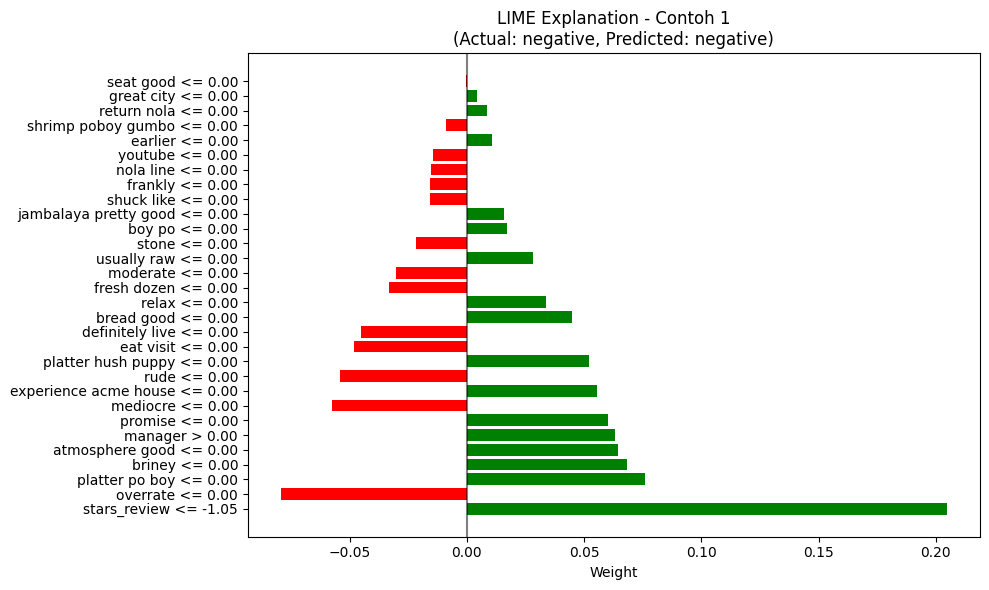


Top Features yang Mempengaruhi Prediksi:
  stars_review <= -1.05: 0.2046 (MENDORONG negative)
  overrate <= 0.00: -0.0792 (MENDORONG positive)
  platter po boy <= 0.00: 0.0761 (MENDORONG negative)
  briney <= 0.00: 0.0682 (MENDORONG negative)
  atmosphere good <= 0.00: 0.0645 (MENDORONG negative)
  manager > 0.00: 0.0630 (MENDORONG negative)
  promise <= 0.00: 0.0602 (MENDORONG negative)
  mediocre <= 0.00: -0.0573 (MENDORONG positive)
  experience acme house <= 0.00: 0.0555 (MENDORONG negative)
  rude <= 0.00: -0.0543 (MENDORONG positive)
  platter hush puppy <= 0.00: 0.0522 (MENDORONG negative)
  eat visit <= 0.00: -0.0482 (MENDORONG positive)
  definitely live <= 0.00: -0.0452 (MENDORONG positive)
  bread good <= 0.00: 0.0449 (MENDORONG negative)
  relax <= 0.00: 0.0337 (MENDORONG negative)
  fresh dozen <= 0.00: -0.0330 (MENDORONG positive)
  moderate <= 0.00: -0.0302 (MENDORONG positive)
  usually raw <= 0.00: 0.0284 (MENDORONG negative)
  stone <= 0.00: -0.0217 (MENDORONG positi

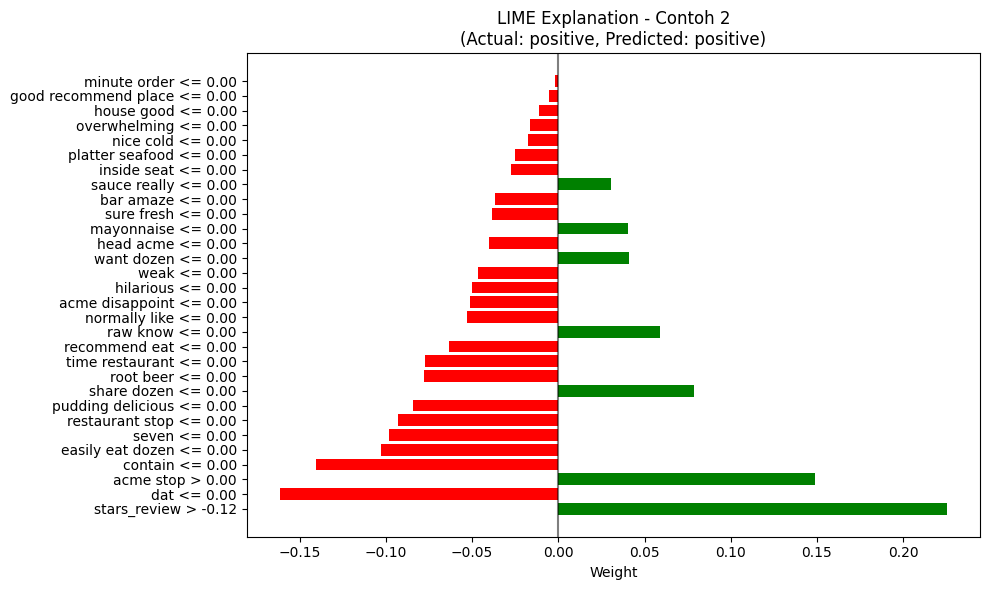


Top Features yang Mempengaruhi Prediksi:
  stars_review > -0.12: 0.2252 (MENDORONG positive)
  dat <= 0.00: -0.1615 (MENDORONG negative)
  acme stop > 0.00: 0.1491 (MENDORONG positive)
  contain <= 0.00: -0.1406 (MENDORONG negative)
  easily eat dozen <= 0.00: -0.1030 (MENDORONG negative)
  seven <= 0.00: -0.0981 (MENDORONG negative)
  restaurant stop <= 0.00: -0.0931 (MENDORONG negative)
  pudding delicious <= 0.00: -0.0841 (MENDORONG negative)
  share dozen <= 0.00: 0.0789 (MENDORONG positive)
  root beer <= 0.00: -0.0780 (MENDORONG negative)
  time restaurant <= 0.00: -0.0773 (MENDORONG negative)
  recommend eat <= 0.00: -0.0632 (MENDORONG negative)
  raw know <= 0.00: 0.0591 (MENDORONG positive)
  normally like <= 0.00: -0.0529 (MENDORONG negative)
  acme disappoint <= 0.00: -0.0509 (MENDORONG negative)
  hilarious <= 0.00: -0.0502 (MENDORONG negative)
  weak <= 0.00: -0.0467 (MENDORONG negative)
  want dozen <= 0.00: 0.0408 (MENDORONG positive)
  head acme <= 0.00: -0.0404 (MENDO

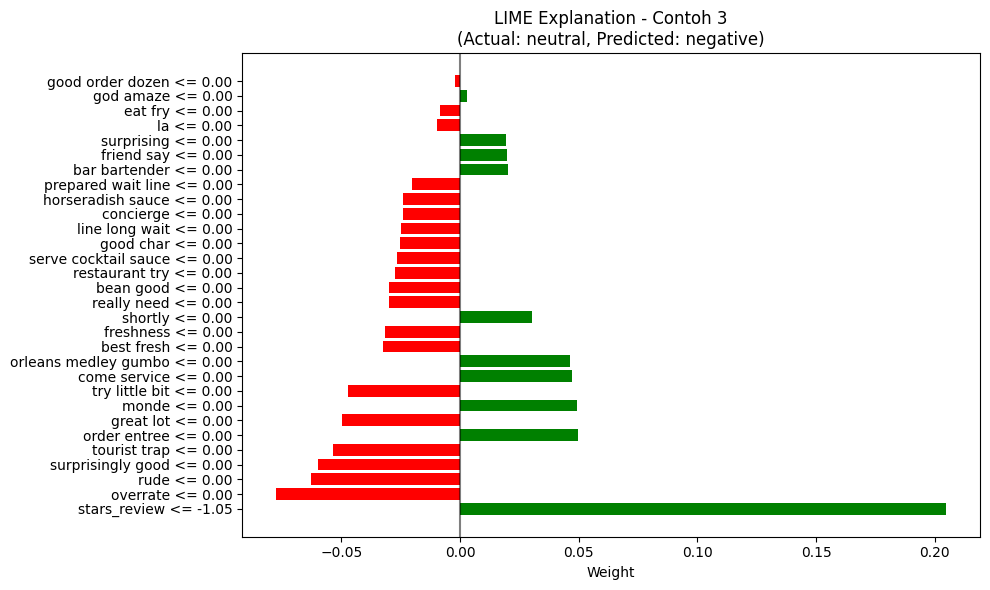


Top Features yang Mempengaruhi Prediksi:
  stars_review <= -1.05: 0.2049 (MENDORONG negative)
  overrate <= 0.00: -0.0776 (MENDORONG positive)
  rude <= 0.00: -0.0628 (MENDORONG positive)
  surprisingly good <= 0.00: -0.0600 (MENDORONG positive)
  tourist trap <= 0.00: -0.0536 (MENDORONG positive)
  order entree <= 0.00: 0.0495 (MENDORONG negative)
  great lot <= 0.00: -0.0495 (MENDORONG positive)
  monde <= 0.00: 0.0495 (MENDORONG negative)
  try little bit <= 0.00: -0.0473 (MENDORONG positive)
  come service <= 0.00: 0.0470 (MENDORONG negative)
  orleans medley gumbo <= 0.00: 0.0462 (MENDORONG negative)
  best fresh <= 0.00: -0.0325 (MENDORONG positive)
  freshness <= 0.00: -0.0318 (MENDORONG positive)
  shortly <= 0.00: 0.0305 (MENDORONG negative)
  really need <= 0.00: -0.0300 (MENDORONG positive)
  bean good <= 0.00: -0.0298 (MENDORONG positive)
  restaurant try <= 0.00: -0.0273 (MENDORONG positive)
  serve cocktail sauce <= 0.00: -0.0265 (MENDORONG positive)
  good char <= 0.00:

In [19]:

training_sample = X_train_combined_resampled[:].toarray()

explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    training_data=training_sample,
    feature_names=feature_names,
    class_names=label_encoder.classes_,
    mode='classification',
    random_state=42
)

# Pilih beberapa contoh untuk dijelaskan
print("Memilih contoh untuk interpretasi LIME...")

# Cari contoh untuk setiap kelas yang diprediksi dengan confidence tinggi
y_test_proba = best_xgb_model.predict_proba(X_test_combined)
y_test_pred = best_xgb_model.predict(X_test_combined)

examples_to_explain = []
for class_idx, class_name in enumerate(label_encoder.classes_):
    # Cari contoh dengan prediksi kelas tertentu dan confidence tinggi
    class_indices = np.where((y_test == class_idx) & (y_test_proba[:, class_idx] > 0.7))[0]
    if len(class_indices) > 0:
        examples_to_explain.append(class_indices[0])

# Jika tidak cukup contoh, tambahkan contoh pertama dari setiap kelas
if len(examples_to_explain) < len(label_encoder.classes_):
    for class_idx in range(len(label_encoder.classes_)):
        if class_idx not in [y_test[i] for i in examples_to_explain]:
            class_indices = np.where(y_test == class_idx)[0]
            if len(class_indices) > 0:
                examples_to_explain.append(class_indices[0])

# Batasi maksimal 3 contoh (satu per kelas)
examples_to_explain = examples_to_explain[:3]

for i, example_idx in enumerate(examples_to_explain):
    print(f"\n--- Contoh {i+1} ---")

    # Get instance untuk dijelaskan
    instance = X_test_combined[example_idx].toarray().reshape(1, -1)[0]
    true_label = y_test[example_idx]
    predicted_label = y_test_pred[example_idx]
    predicted_proba = y_test_proba[example_idx]

    # Dapatkan teks asli
    original_text = test_df.iloc[example_idx]['normalized_text']
    lemmatized_text = test_df.iloc[example_idx]['lemmatized_ml_text']

    print(f"Original Text: {original_text[:200]}...")
    print(f"Lemmatized Text: {lemmatized_text[:200]}...")
    print(f"Actual: {label_encoder.classes_[true_label]}")
    print(f"Predicted: {label_encoder.classes_[predicted_label]}")
    print("Prediction Probabilities:")
    for j, class_name in enumerate(label_encoder.classes_):
        print(f"  {class_name}: {predicted_proba[j]:.4f}")

    # LIME explanation
    print("\nLIME Explanation:")

    exp = explainer_lime.explain_instance(
        instance,
        best_xgb_model.predict_proba,
        num_features=30,
        top_labels=3
    )

    # Tampilkan explanation untuk prediksi yang dipilih
    label_to_explain = predicted_label

    try:
        # Tampilkan explanation sebagai list
        explanation_list = exp.as_list(label=label_to_explain)

        # Buat plot manual
        plt.figure(figsize=(10, 6))

        # Ambil features dan weights
        features = [x[0] for x in explanation_list[:30]]
        weights = [x[1] for x in explanation_list[:30]]

        # Warna berdasarkan interpretasi
        colors = ['green' if x > 0 else 'red' for x in weights]

        # Buat horizontal bar plot
        y_pos = np.arange(len(features))
        plt.barh(y_pos, weights, color=colors)
        plt.yticks(y_pos, features)
        plt.xlabel('Weight')
        plt.title(f"LIME Explanation - Contoh {i+1}\n(Actual: {label_encoder.classes_[true_label]}, Predicted: {label_encoder.classes_[predicted_label]})")

        # Tambah garis vertikal di 0
        plt.axvline(x=0, color='black', linestyle='-', alpha=0.5)

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error dalam menampilkan plot LIME: {e}")
        # Fallback: tampilkan sebagai text saja
        print("\nTop Features yang Mempengaruhi Prediksi (Text Only):")
        for feature, weight in explanation_list[:30]:
            if weight > 0:
                influence = f"MENDORONG {label_encoder.classes_[label_to_explain]}"
            else:
                # Cari kelas dengan probabilitas tertinggi selain yang diprediksi
                other_probs = [(j, prob) for j, prob in enumerate(predicted_proba) if j != label_to_explain]
                if other_probs:
                    other_class_idx = max(other_probs, key=lambda x: x[1])[0]
                    influence = f"MENDORONG {label_encoder.classes_[other_class_idx]}"
                else:
                    influence = "MENDORONG kelas lain"
            print(f"  {feature}: {weight:.4f} ({influence})")
        continue

    # Tampilkan fitur yang paling berpengaruh
    print("\nTop Features yang Mempengaruhi Prediksi:")
    for feature, weight in explanation_list[:30]:
        if weight > 0:
            influence = f"MENDORONG {label_encoder.classes_[label_to_explain]}"
        else:
            other_probs = [(j, prob) for j, prob in enumerate(predicted_proba) if j != label_to_explain]
            if other_probs:
                other_class_idx = max(other_probs, key=lambda x: x[1])[0]
                influence = f"MENDORONG {label_encoder.classes_[other_class_idx]}"
            else:
                influence = "MENDORONG kelas lain"
        print(f"  {feature}: {weight:.4f} ({influence})")

# Save Model

In [20]:
model_artifacts = {
    'model': best_xgb_model,
    'tfidf_vectorizer': tfidf_vectorizer,
    'scaler': scaler,
    'label_encoder': label_encoder,
    'feature_names': feature_names,
    'numerical_features': numerical_features
}

joblib.dump(model_artifacts, 'Sentiment_Analysis_RF.pkl')

['Sentiment_Analysis_RF.pkl']